Figures 2a, 2b and 3 from my SIAM News publication in 2015: http://www.moresi.info/posts/Computational-Challenges-SIAM-NEWS/

Caption, Figure 2 - _One of the most dramatic departures from plate-like deformation on Earth occurs where the Indian subcontinent is colliding with the Eurasian continent. The map on the left is a satellite image with the flow lines from the plate motion vector field drawn in red. On the right is the same region showing 50 years of earthquake data for events larger than magnitude 4.5, colored by depth and superimposed on the strain rate._

Caption, Figure 3 - _A low-angle view of a numerical model of continental collision using the Underworld particle-in-cell finite element code. **The map (1) shows the how to interpret the model in terms of the India-Eurasia collision.** In the movie, the (Indian) indentor heads towards the viewer and crumples the crust into a mountain belt in the foreground. In the background, the crust escapes away from the viewer pulled by the subduction zone in the background. Snapshots from the movie: (2), pre-collision and (3), late in the collision._


In [1]:
%pylab inline


from osgeo import gdal
from osgeo import gdal_array


import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from cartopy.io import PostprocessedRasterSource, LocatedImage
from cartopy.io import srtm
from cartopy.io.srtm import SRTM3Source
import cartopy.feature as cfeature

import scipy.ndimage
import scipy.misc

from scipy.io import netcdf

Populating the interactive namespace from numpy and matplotlib


In [2]:
# The colormap routine creates enormous arrays in intermediary calculations. This is
# a way to avoid memory errors: process to RGB (int8) in advance

def apply_colormap_to_image(rawimage, colormap, norm):

    greyimage = norm(rawimage)
    rgbimage = np.empty((greyimage.shape[0], greyimage.shape[1] , 4), dtype=uint8)

    for i in range(0, greyimage.shape[0]):
        rgbimage[i,:,:] = colormap(greyimage[i,:]) * 256
                
    rgbimage2 = rgbimage[:,:,0:3]        
    
    return rgbimage2
    

In [3]:
base_projection     = ccrs.PlateCarree() 
global_extent     = [-180.0, 180.0, -90.0, 90.0]

etopo1       = gdal.Open("../../Data/Resources/color_etopo1_ice_low.tif")
etopo_img    = etopo1.ReadAsArray().transpose(1,2,0)
del(etopo1)

# Height field only ... 
etopoH = gdal.Open("../../Data/Resources/ETOPO1_Ice_c_geotiff.tif") 
etopoH_img = etopoH.ReadAsArray()[::2,::2].astype(numpy.float16)
del(etopoH)

colormap = plt.get_cmap('Greys_r')
norm = matplotlib.colors.Normalize(vmin=-5000, vmax=7500)
etopoH_img_grey = apply_colormap_to_image(etopoH_img, colormap, norm)

strainrate_extent=[-180,180,-68,80]
strainrate = numpy.loadtxt("../../Data/Resources/sec_invariant_strain_0.2.dat")
strainrate_data = strainrate.reshape(741,1800,3)  # I had to look at the data to work this out !

globalrelief      = gdal.Open("../../Data/Resources/HYP_50M_SR_W/HYP_50M_SR_W.tif")
globalrelief_img  = globalrelief.ReadAsArray().transpose(1,2,0)
del(globalrelief)

globalbathym      = gdal.Open("../../Data/Resources/OB_50M/OB_50M.tif")
globalbathym_img  = globalbathym.ReadAsArray().transpose(1,2,0)
del(globalbathym)

print ("etopoH_img - ", etopoH_img.shape)
print ("globalrelief_img - ", globalrelief_img.shape)

## If the shapes are different then see the cell below for a way to fix it.

blended_img = np.empty_like(globalrelief_img)
blended_img[...,0] = np.where( etopoH_img < 0.0, globalbathym_img[...,0], globalrelief_img[...,0] )
blended_img[...,1] = np.where( etopoH_img < 0.0, globalbathym_img[...,1], globalrelief_img[...,1] )
blended_img[...,2] = np.where( etopoH_img < 0.0, globalbathym_img[...,2], globalrelief_img[...,2] )

# Clean up ... we'll just keep the int8 rgb versions for plotting

del(globalbathym_img)
del(globalrelief_img)
del(etopoH_img)

etopoH_img -  (5400, 10800)
globalrelief_img -  (5400, 10800, 3)


In [4]:
# Do this if the relief / bathym sizes don't match the etopo data (to make the blended image)
# The datasets we downloaded can be manipulated trivially without the need for this and I have
# commented it all out so you can run all cells without reprocessing the data files. 


"""
import scipy.ndimage
import scipy.misc


etopoH = gdal.Open("Resources/ETOPO1_Ice_g_geotiff.tif")
etopoH_img = etopoH.ReadAsArray()

print 

etopoH_transform = etopoH.GetGeoTransform()
globalrelief_transform = globalrelief.GetGeoTransform()

# Resize to match globalrelief ... this resize is int only ??

globaletopoH = scipy.misc.imresize(etopoH_img, globalrelief_img.shape, mode='F')

## How to turn this array back into the appropriate geotiff

from osgeo import gdal
from osgeo import osr

# data exists in 'ary' with values range 0 - 255
# Uncomment the next line if ary[0][0] is upper-left corner
#ary = numpy.flipup(ary)

Ny, Nx = globaletopoH.shape
driver = gdal.GetDriverByName("GTiff")
# Final argument is optional but will produce much smaller output file
ds = driver.Create('output.tif', Nx, Ny, 1, gdal.GDT_Float64, ['COMPRESS=LZW'])

# this assumes the projection is Geographic lat/lon WGS 84
srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)
ds.SetProjection(srs.ExportToWkt())

ds.SetGeoTransform( globalrelief_transform  ) # define GeoTransform tuple
ds.GetRasterBand(1).WriteArray(globaletopoH)
ds = None
"""

pass


In [5]:
# img_heights  = etopo_img.reshape(-1)

base_projection = ccrs.PlateCarree()
global_extent = [ -180, 180, -90, 90 ]

coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m',
                           edgecolor=(0.0,0.0,0.0),
                           facecolor="none")

rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m',
                                        edgecolor='Blue', facecolor="none")

lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                        edgecolor="blue", facecolor="blue")

ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                           edgecolor="green",
                           facecolor="blue")

graticules_5 = cfeature.NaturalEarthFeature('physical', 'graticules_5', '10m',
                           edgecolor="black", facecolor=None)


In [6]:
from obspy.core import event
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

client = Client("IRIS")

himalaya_extent = [65, 110, 5, 45 ]

starttime = UTCDateTime("1965-01-01")
endtime   = UTCDateTime("2016-01-01")
cat = client.get_events(starttime=starttime, endtime=endtime,
                        minlongitude=himalaya_extent[0],
                        maxlongitude=himalaya_extent[1],
                        minlatitude=himalaya_extent[2],
                        maxlatitude=himalaya_extent[3],
                        minmagnitude=4.5, catalog="ISC")

print (cat.count(), " events in catalogue")

16387  events in catalogue


In [7]:
# Unpack the opspy data into a plottable array

event_count = cat.count()

eq_origins = np.zeros((event_count, 5))

for ev, event in enumerate(cat.events):
    eq_origins[ev,0] = dict(event.origins[0])['longitude']
    eq_origins[ev,1] = dict(event.origins[0])['latitude']
    eq_origins[ev,2] = dict(event.origins[0])['depth']
    eq_origins[ev,3] = dict(event.magnitudes[0])['mag']
    eq_origins[ev,4] = (dict(event.origins[0])['time']).date.year



In [8]:

rootgrp = netcdf.netcdf_file(filename="../../Data/Reference/velocity_EU.nc", version=2)

ve = rootgrp.variables["ve"]
vn = rootgrp.variables["vn"]

lonv = rootgrp.variables["lon"]
latv = rootgrp.variables["lat"]

lons = lonv[::1]
lats = latv[::1]
llX, llY = np.meshgrid(lons,lats)

#llX = llX.reshape(-1)
#llY = llY.reshape(-1)

Veast = (np.array(ve[::1,::1]).T)
Vnorth = (np.array(vn[::1,::1]).T)

Vorientation = np.arctan2(Vnorth,Veast)
Vspeed = np.sqrt(Veast**2 + Vnorth**2)


/usr/local/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/physical/ne_50m_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


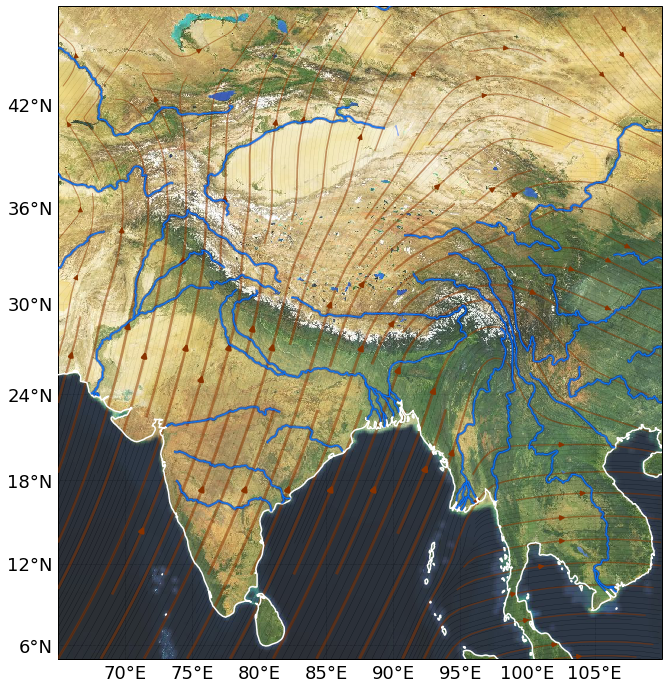

In [9]:
## Figure 2a is a land / ocean image with coastlines and rivers over the top.
## The red / grey lines are streamlines of the plate motion data which show trajectories in 
## a way which is not as intrusive as a bunch of arrows.

from matplotlib.transforms import offset_copy

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import gdal
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker


# Map / Image Tile machinery


mapbox_satellite = cimgt.MapboxTiles(map_id='satellite', 
                                     access_token='pk.eyJ1IjoibG91aXNtb3Jlc2kiLCJhIjoiY2pzeG1mZzFqMG5sZDQ0czF5YzY1NmZ4cSJ9.lpsUzmLasydBlS0IOqe5JA')


mapbox_streets = cimgt.MapboxTiles(map_id='streets', 
                                     access_token='pk.eyJ1IjoibG91aXNtb3Jlc2kiLCJhIjoiY2pzeG1mZzFqMG5sZDQ0czF5YzY1NmZ4cSJ9.lpsUzmLasydBlS0IOqe5JA')


## Google maps image tiles ()
google_maps_street = cimgt.GoogleTiles(style="street") 
google_maps_satellite = cimgt.GoogleTiles(style="satellite") 
google_maps_terrain = cimgt.GoogleTiles(style="terrain") 

# Choose one of the services above. I used map_tiles = mapbox_satellite for the published 
# plot, but this does require registration here: https://www.mapbox.com/help/create-api-access-token/
# The map_quest image does not seem to be registered correctly with the coastline so I am probably doing something
# wrong. But the mapbox one looks perfectly fine !

map_tiles = mapbox_satellite

fig = plt.figure(figsize=(12, 12), facecolor="none")
# ax = plt.axes(projection=ccrs.PlateCarree(), extent=himalaya_extent)

# Create a GeoAxes in the tile's projection.
ax = plt.axes(projection=map_tiles.crs)

    # Limit the extent of the map to a small longitude/latitude range.
ax.set_extent(himalaya_extent)

    # Add the MapQuest data at zoom level 8.
    
ax.streamplot(lons, lats, Veast, Vnorth, linewidth=0.25, color='black', 
              cmap=cm.gray_r, density=5.0, transform=ccrs.PlateCarree(), zorder=0, arrowstyle='-')

ax.add_image(map_tiles, 5, alpha=0.85, zorder=2)

streamlines = ax.streamplot(lons, lats, Veast, Vnorth, linewidth=1+Vspeed*0.05, color='#883300', cmap=cm.Reds_r,
              transform=ccrs.PlateCarree(), zorder=4)

streamlines.lines.set_alpha(0.5)


ax.add_feature(coastline, linewidth=1.5,  edgecolor="White", zorder=10)
ax.add_feature(rivers,    linewidth=1.0,    edgecolor="#0077FF", zorder=13)
ax.add_feature(rivers,    linewidth=3.0,    edgecolor="#002299",    zorder=12, alpha=0.5)
ax.add_feature(lakes,     linewidth=0,    edgecolor="Blue", facecolor="#4477FF", zorder=11, alpha=0.5)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='#222222', alpha=1.0, linestyle=':' )

gl.xlabels_top = False
gl.ylabels_right = False
# gl.xlines = False
# gl.xlines = False


gl.xlocator = mticker.FixedLocator(np.arange(65,110,5))
glyxlocator = mticker.FixedLocator(np.arange(5,45,5))

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}


In [10]:
fig.savefig("HimalayaRivers.png", dpi=300)

In [ ]:
## This is figure 2b ... greyscale topography and bathymetry with strain rate contours and 
## earthquake hypocentres plotted on top


import gdal
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker


fig = plt.figure(figsize=(12, 12), facecolor="none")
ax = plt.axes(projection=ccrs.PlateCarree(), extent=himalaya_extent)

ax.imshow(etopoH_img_grey, transform=ccrs.PlateCarree(), origin="upper", 
           alpha=1.0, extent=global_extent, interpolation="spline16", zorder=1)

mappable2 = ax.contourf(strainrate_data[:,:,0], strainrate_data[:,:,1], strainrate_data[:,:,2], 
         levels=[ 25, 50, 75 , 100, 150, 200, 250, 300 ], linestyle=None, vmin=5.0, vmax=300,
         transform=base_projection,  cmap=cm.OrRd_r, alpha=0.95, linewidth=2.0,
         extent=strainrate_extent, extend="max", zorder=12)


# plt.colorbar(mappable=mappable2)

ax.add_feature(coastline, linewidth=1.5,  edgecolor="Black", zorder=10)
# ax.add_feature(rivers,    linewidth=1,    edgecolor="Blue", zorder=12)
# ax.add_feature(lakes,     linewidth=1,    edgecolor="Blue", zorder=13, alpha=0.25)
# ax.add_feature(graticules_5,     linewidth=0.5, linestyle=":",    edgecolor="gray", zorder=4, alpha=0.75)


# ax.add_feature(ocean, facecolor=(0.4,0.4,0.6), edgecolor=(0.0,0.0,0.0), linewidth=1, alpha=0.75, zorder=4)

depth_scale = ax.scatter(eq_origins[:,0], eq_origins[:,1], 50.0*(eq_origins[:,3]-4.5), c=eq_origins[:,2], marker='o', 
               cmap=cm.Blues_r, vmin=35000, vmax=100000, alpha = 0.85, linewidth=0.5, zorder=20)


# plt.colorbar(mappable=depth_scale)


## Labels

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='#222222', alpha=1.0, linestyle=':' )

gl.xlabels_top = False
gl.ylabels_left = False
# gl.xlines = False
# gl.xlines = False


gl.xlocator = mticker.FixedLocator(np.arange(65,110,5))
glyxlocator = mticker.FixedLocator(np.arange(5,45,5))

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}


## Legendary stuff 
#  For the published figure, I used these circles to give me the scale and colour
# but made my own legend in a drawing program

mag4_color     = cm.Blues( 1.0 )
mag4_dot35km   = ax.scatter(66.0, 6.0, 50.0*(4.6-4.5), marker='o', color=mag4_color,
                 vmin=30000, vmax=100000, alpha = 0.85, linewidth=0.5, zorder=21)

mag5_color     = cm.Blues( 1.0- (50 - 30) / 70 )
mag5_dot50km   = ax.scatter(66.0, 7.0, 50.0*(5.0-4.5), marker='o', color=mag5_color,
                 vmin=30000, vmax=100000, alpha = 0.85, linewidth=0.5, zorder=21)

mag6_color     = cm.Blues(1.0- (70 - 30) / 70 )
mag6_dot70km   = ax.scatter(66.0, 8.0, 50.0*(6.0-4.5), marker='o', color=mag6_color,
                 vmin=30000, vmax=100000, alpha = 0.85, linewidth=0.5, zorder=21)

mag7_color     = cm.Blues( 0.0 )
mag7_dot100km   = ax.scatter(66.0, 9.0, 50.0*(7.0-4.5), marker='o', color=mag7_color,
                 vmin=30000, vmax=100000, alpha = 0.85, linewidth=0.5, zorder=21)


In [ ]:
fig.savefig("HimalayaEQ.png", dpi=300)

In [ ]:
## Figure 3a is the regional setting which is used as a base to draw an
## interpretation of some 3D models. 

himalaya_region_extent = [ 55 , 135, -20, 45 ]

map_tiles = mapbox_satellite

fig = plt.figure(figsize=(12, 12), facecolor="none")
# ax = plt.axes(projection=ccrs.PlateCarree(), extent=himalaya_extent)

# Create a GeoAxes in the tile's projection.
ax = plt.axes(projection=map_tiles.crs)

# Limit the extent of the map

ax.set_extent(himalaya_region_extent)

ax.add_image(map_tiles, 5, alpha=0.45, zorder=2)

ax.add_feature(coastline, linewidth=1.5,  edgecolor="Black", zorder=1)




In [ ]:
fig.savefig("HimalayaRegionalMap.png", dpi=300)

In [ ]:
## An alternative to Figure 2a !


theCM = cm.get_cmap('Oranges')
theCM._init()

alphas = np.abs(np.linspace(0.0, 1.0, theCM.N))
theCM._lut[:-3,-1] = alphas**0.25

fig = plt.figure(figsize=(12, 12), facecolor="none")
ax = plt.axes(projection=ccrs.PlateCarree(), extent=himalaya_extent)
# plt.imshow(strainrate_img, cmap=theCM, origin="lower", interpolation="spline16", extent=strainrate_extent, 
#             vmin=-1, vmax=100)

plt.imshow(etopo_img, transform=ccrs.PlateCarree(), extent=[-180,180,-90,90], alpha=0.5)

ax.contourf(strainrate_data[:,:,0], strainrate_data[:,:,1], strainrate_data[:,:,2], 
         levels=[20,30,40,50], linewidth=0.0, vmin=20.0, vmax=200,
         transform=base_projection,  cmap="YlOrRd", zorder=2, alpha=0.25, extent=strainrate_extent)

ax.contourf(strainrate_data[:,:,0], strainrate_data[:,:,1], strainrate_data[:,:,2], 
         levels=[60,70,80,90,100, 200], linewidth=0.0, vmin=20.0, vmax=200,
         transform=base_projection,  cmap="YlOrRd", zorder=2, alpha=0.5, extent=strainrate_extent)

ax.add_feature(coastline, linewidth=1.5,  edgecolor="Black", zorder=1)
ax.add_feature(rivers,    linewidth=1,    edgecolor="Blue", zorder=2)
ax.add_feature(lakes,     linewidth=1,    edgecolor="Blue", zorder=3, alpha=0.25)

